In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(42)


In [10]:
def generate_synthetic_data(num_samples_per_class, num_classes, num_features):
    total_samples = num_samples_per_class * num_classes
    X = np.zeros((total_samples, num_features))
    y = np.zeros(total_samples, dtype=int)

    centers = [(-2.0, -2.0), (-2.0, 2.0), (0.0, 0.0), (2.0, -2.0), (2.0, 2.0)]
    centers = centers[:num_classes]

    idx = 0
    for class_id, (cx, cy) in enumerate(centers):
        samples = np.random.randn(num_samples_per_class, num_features)
        samples[:, 0] += cx
        samples[:, 1] += cy
        X[idx:idx + num_samples_per_class] = samples
        y[idx:idx + num_samples_per_class] = class_id
        idx += num_samples_per_class

    perm = np.random.permutation(total_samples)
    X = X[perm]
    y = y[perm]
    return X, y

X, y = generate_synthetic_data(num_samples_per_class=4000, num_classes=5, num_features=2)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))
print("Class counts:", {i: int(np.sum(y == i)) for i in range(5)})


X shape: (20000, 2)
y shape: (20000,)
Unique classes: [0 1 2 3 4]
Class counts: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000}


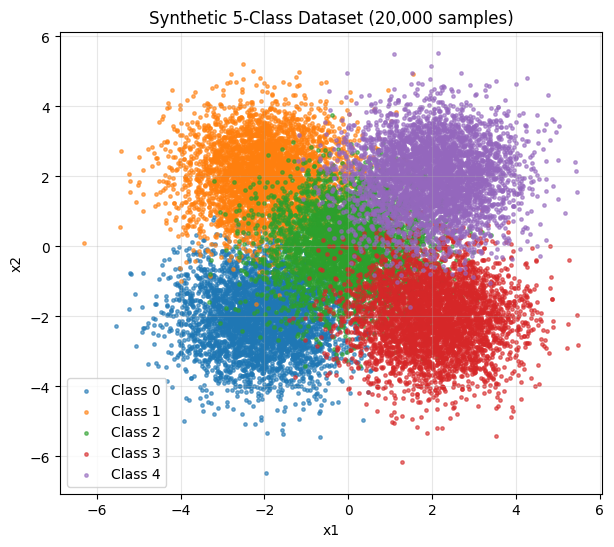

In [11]:
plt.figure(figsize=(7, 6))
for cls in range(5):
    idx = (y == cls)
    plt.scatter(X[idx, 0], X[idx, 1], s=6, label=f"Class {cls}", alpha=0.6)

plt.title("Synthetic 5-Class Dataset (20,000 samples)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
def one_hot(y, num_classes):
    Y = np.zeros((len(y), num_classes), dtype=np.float32)
    Y[np.arange(len(y)), y] = 1.0
    return Y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Y_train = one_hot(y_train, 5)
Y_test  = one_hot(y_test, 5)

print("Train X:", X_train.shape, "Train y:", y_train.shape, "Train Y:", Y_train.shape)
print("Test  X:", X_test.shape,  "Test  y:", y_test.shape,  "Test  Y:", Y_test.shape)


Train X: (16000, 2) Train y: (16000,) Train Y: (16000, 5)
Test  X: (4000, 2) Test  y: (4000,) Test  Y: (4000, 5)


In [13]:
mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - mu) / sigma
X_test_n  = (X_test  - mu) / sigma

print("Train normalized mean:", X_train_n.mean(axis=0))
print("Train normalized std :", X_train_n.std(axis=0))


Train normalized mean: [ 1.00232322e-17 -1.41683540e-17]
Train normalized std : [1. 1.]


In [14]:
def relu(z):
    return np.maximum(0.0, z)

def relu_grad(z):
    return (z > 0).astype(np.float32)

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / (np.sum(expz, axis=1, keepdims=True) + 1e-12)


In [15]:
def cross_entropy_loss(Y_true, Y_pred):
    eps = 1e-12
    Y_pred = np.clip(Y_pred, eps, 1.0 - eps)
    return -np.mean(np.sum(Y_true * np.log(Y_pred), axis=1))


In [16]:
class ThreeHiddenLayerNN:
    def __init__(self, input_dim, h1, h2, h3, output_dim, seed=42):
        rng = np.random.default_rng(seed)

        def init_w(in_dim, out_dim):
            return (rng.standard_normal((in_dim, out_dim)).astype(np.float32) * np.sqrt(2.0 / in_dim))

        self.W1 = init_w(input_dim, h1); self.b1 = np.zeros((1, h1), dtype=np.float32)
        self.W2 = init_w(h1, h2);       self.b2 = np.zeros((1, h2), dtype=np.float32)
        self.W3 = init_w(h2, h3);       self.b3 = np.zeros((1, h3), dtype=np.float32)
        self.W4 = init_w(h3, output_dim); self.b4 = np.zeros((1, output_dim), dtype=np.float32)

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)

        z2 = a1 @ self.W2 + self.b2
        a2 = relu(z2)

        z3 = a2 @ self.W3 + self.b3
        a3 = relu(z3)

        z4 = a3 @ self.W4 + self.b4
        probs = softmax(z4)

        cache = (X, z1, a1, z2, a2, z3, a3, z4, probs)
        return probs, cache


In [17]:
def train_step(model, Xb, Yb, lr=0.01):
    probs, cache = model.forward(Xb)
    X, z1, a1, z2, a2, z3, a3, z4, _ = cache
    m = X.shape[0]

    dz4 = (probs - Yb) / m
    dW4 = a3.T @ dz4
    db4 = np.sum(dz4, axis=0, keepdims=True)

    da3 = dz4 @ model.W4.T
    dz3 = da3 * relu_grad(z3)
    dW3 = a2.T @ dz3
    db3 = np.sum(dz3, axis=0, keepdims=True)

    da2 = dz3 @ model.W3.T
    dz2 = da2 * relu_grad(z2)
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = dz2 @ model.W2.T
    dz1 = da1 * relu_grad(z1)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    model.W4 -= lr * dW4; model.b4 -= lr * db4
    model.W3 -= lr * dW3; model.b3 -= lr * db3
    model.W2 -= lr * dW2; model.b2 -= lr * db2
    model.W1 -= lr * dW1; model.b1 -= lr * db1

    return cross_entropy_loss(Yb, probs)


In [18]:
model = ThreeHiddenLayerNN(input_dim=2, h1=32, h2=32, h3=32, output_dim=5, seed=42)

epochs = 120
lr = 0.02

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, epochs + 1):
    _ = train_step(model, X_train_n, Y_train, lr=lr)

    train_probs, _ = model.forward(X_train_n)
    test_probs, _ = model.forward(X_test_n)

    train_loss = cross_entropy_loss(Y_train, train_probs)
    test_loss = cross_entropy_loss(Y_test, test_probs)

    y_train_pred = np.argmax(train_probs, axis=1)
    y_test_pred = np.argmax(test_probs, axis=1)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d} | "
            f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}"
        )


Epoch   1 | Train Loss: 1.6120 | Test Loss: 1.6052 | Train Acc: 0.1663 | Test Acc: 0.1673
Epoch  20 | Train Loss: 0.9958 | Test Loss: 0.9986 | Train Acc: 0.7134 | Test Acc: 0.7130
Epoch  40 | Train Loss: 0.8040 | Test Loss: 0.8062 | Train Acc: 0.7545 | Test Acc: 0.7568
Epoch  60 | Train Loss: 0.7003 | Test Loss: 0.7023 | Train Acc: 0.7646 | Test Acc: 0.7670
Epoch  80 | Train Loss: 0.6359 | Test Loss: 0.6380 | Train Acc: 0.7686 | Test Acc: 0.7708
Epoch 100 | Train Loss: 0.5914 | Test Loss: 0.5937 | Train Acc: 0.7727 | Test Acc: 0.7745
Epoch 120 | Train Loss: 0.5589 | Test Loss: 0.5614 | Train Acc: 0.7772 | Test Acc: 0.7788


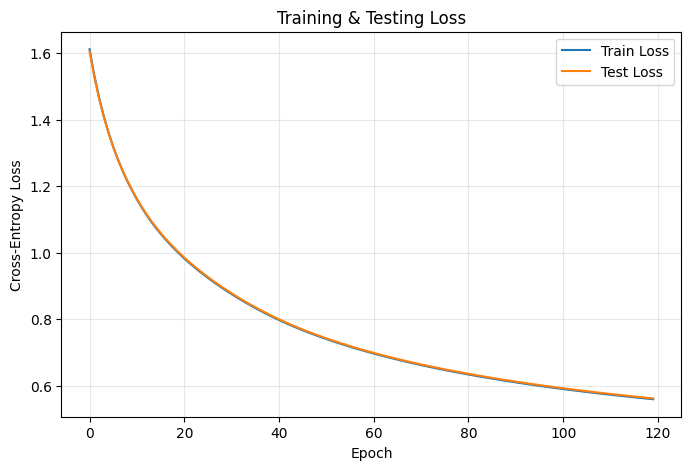

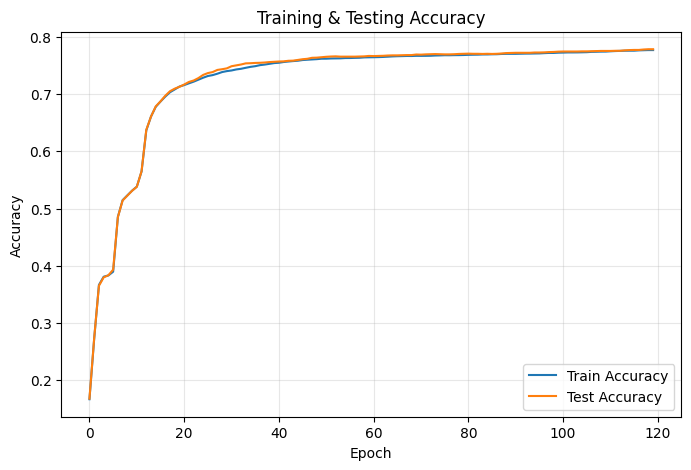

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training & Testing Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Testing Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


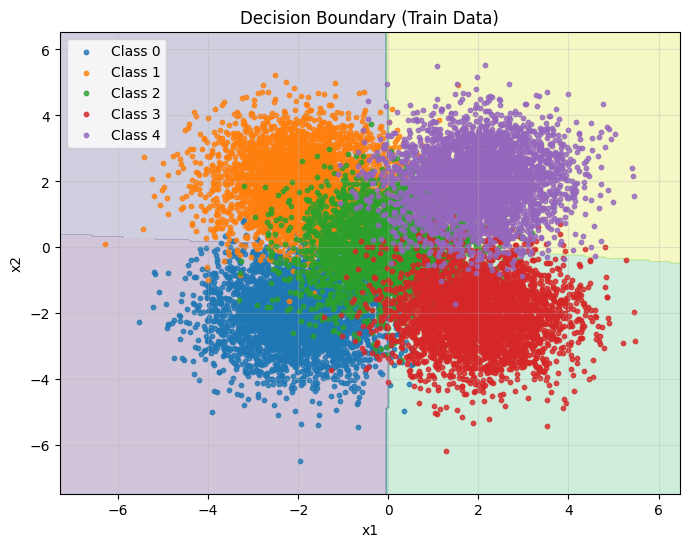

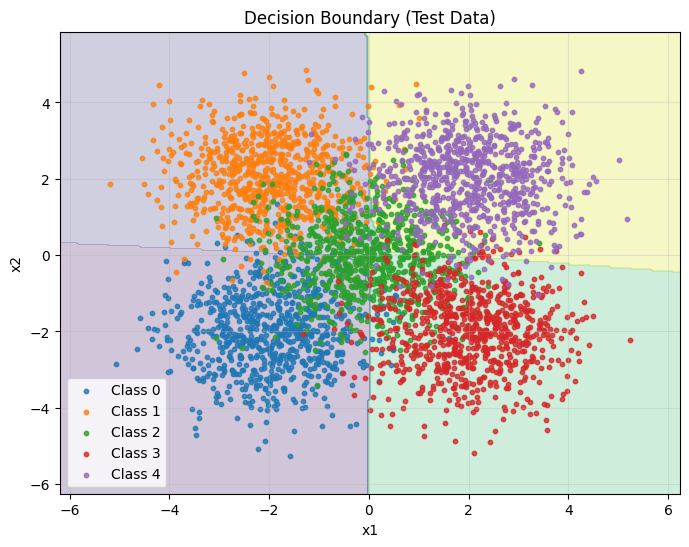

In [21]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    grid_n = (grid - mu) / sigma

    probs, _ = model.forward(grid_n)
    preds = np.argmax(probs, axis=1).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.25)

    for cls in range(5):
        idx = (y == cls)
        plt.scatter(X[idx, 0], X[idx, 1], s=10, label=f"Class {cls}", alpha=0.8)

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_decision_boundary(model, X_train, y_train, "Decision Boundary (Train Data)")
plot_decision_boundary(model, X_test, y_test, "Decision Boundary (Test Data)")


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

test_probs, _ = model.forward(X_test_n)
y_test_pred = np.argmax(test_probs, axis=1)

print("Final Train Accuracy:", accuracy_score(y_train, np.argmax(model.forward(X_train_n)[0], axis=1)))
print("Final Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, digits=4))


Final Train Accuracy: 0.77725
Final Test Accuracy : 0.77875

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.7752    0.9437    0.8512       800
           1     0.7705    0.9650    0.8568       800
           2     0.8800    0.0825    0.1509       800
           3     0.7656    0.9513    0.8484       800
           4     0.7969    0.9513    0.8672       800

    accuracy                         0.7788      4000
   macro avg     0.7976    0.7787    0.7149      4000
weighted avg     0.7976    0.7788    0.7149      4000



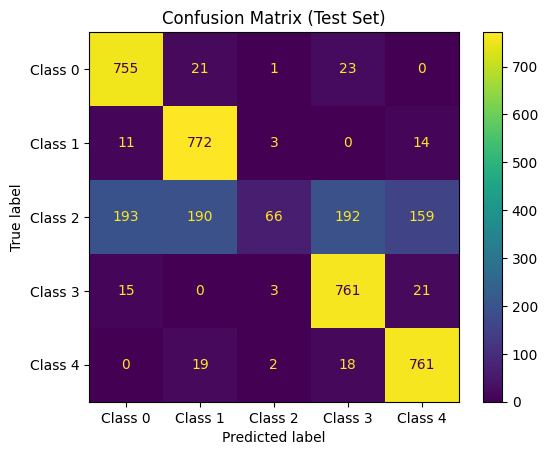

Confusion Matrix (rows=True, cols=Pred):
 [[755  21   1  23   0]
 [ 11 772   3   0  14]
 [193 190  66 192 159]
 [ 15   0   3 761  21]
 [  0  19   2  18 761]]


In [23]:
cm = confusion_matrix(y_test, y_test_pred, labels=list(range(5)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(5)])
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

print("Confusion Matrix (rows=True, cols=Pred):\n", cm)


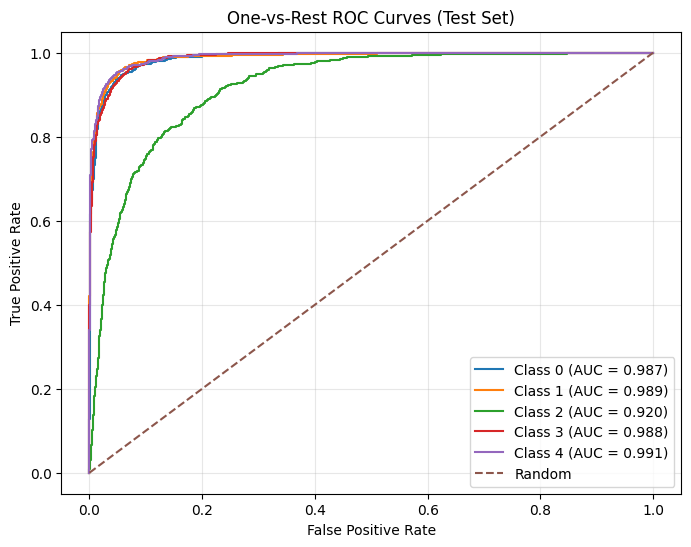

In [24]:
y_test_bin = label_binarize(y_test, classes=list(range(5)))
y_score = test_probs

plt.figure(figsize=(8, 6))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (Test Set)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Challenges and Solutions

Class 4 overlap: Since Class 4 is in the center, some points overlap with other clusters. We used normalization and trained for enough epochs to reduce errors.

Softmax / loss stability: To avoid numerical issues, we used stable softmax (logit shifting) and a small epsilon in cross-entropy.

Backprop shape bugs: We fixed dimension/broadcasting errors by checking gradient shapes layer by layer.

# Results and Observations

The 3-hidden-layer NN classified the 5 classes well. Most mistakes came from Class 4 due to overlap.

Train and test loss decreased smoothly, showing stable learning.

The model achieved high accuracy, and the classification report showed strong precision, recall, and F1-scores.

The decision boundary plots showed clear separation of the five regions, matching the dataset structure